# COMPARING R AND PYTHON LIBRARIES
 
This notebook was designed to compare Extreme Precipitation Climate Indices computations (EPCI) using [Climpact](https://github.com/ARCCSS-extremes/climpact) based in R and [XClim](https://xclim.readthedocs.io/en/stable/notebooks/example.html#Creating-xarray-datasets) based in Python Xarray.
 
The datasate used for the comparison is the Climpact sample netCDF file, that can be access through the GitHub page. The version of the file used in this workbook was downloaded on 14/06/2021 and can be found here (ADD LINK TO THE FILE) 

## The process
- Xclim
    - the precipitation units for the sample dataset need to be changed to mm d-1, this was done using the following command in nco `ncatted -O -a units,precip,m,c,"mm d-1" in.nc`

- Before loading the data 

---

## Indicators comparison

### 1. Settings
*(cl refers to climpact and xc refers to xclim*)

In [1]:
# Imports for xclim and xarray
import xclim as xc
import pandas as pd
import numpy as np
from numpy import exp
import xarray as xr
import scipy.stats as stats
from scipy.stats import rankdata
from scipy.stats import norm
from scipy.stats import anderson
from scipy.stats import shapiro
from scipy.stats import boxcox
from math import ceil

# File handling libraries
import time
import tempfile
from pathlib import Path

# import plotting stuff
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import statsmodels.api as sm
%matplotlib inline
# Set some plotting defaults
plt.rcParams['figure.figsize'] = (15, 11)
plt.rcParams['figure.dpi'] = 100

# import comparison
import pyCompare

# Data folders
input_folder = Path('/mnt/d/MRes_dataset/search_data/climpact_nc_example')
# Output folder
output_folder = '/mnt/d/MRes_dataset/search_data/evaluating_tools/xclim_outputs'
# uncomment below to check if it is the right path
!ls {input_folder}

climpact_R_outputs
climpact_R_outputs_exampleData
climpact_R_outputs_exampleData_notebookWork
climpact_sampledata_gridded_1991_2010-xclim.nc
climpact_sampledata_gridded_1991_2010.nc
daily_imerg_precipitation_2001.nc
daily_imerg_precipitation_2001_final.nc
daily_imerg_precipitation_2001_final3b.nc


In [2]:
# Funtions
def norm_anderson(data):   
    result = anderson(data)
    print('Statistic: %.3f' % result.statistic)
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

def norm_shapiro(data):   
    result = shapiro(data)
    k2, p = shapiro(data)
    alpha = 1e-3
    print("p = {:g}".format(p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print('data does not look normal (reject H0)')
    else:
        print('data looks normal (fail to reject H0)')

        
def rounding(flt_value):
    dcml_cnt = 2
    rnd_val = ceil(flt_value * 10 ** dcml_cnt) / 10 ** dcml_cnt
    return rnd_val

In [52]:
# Global variables

# Define years list between 1991 and 2010
str_yr = 1991
end_yr = 2010
yrs_lt = list(range(str_yr, end_yr + 1, 1))

### 2. EPCI computations Xclim

#### 2.1. Loading and reading nc file

In [5]:
xc_dataset = xr.load_dataset(input_folder / 'climpact_sampledata_gridded_1991_2010-xclim.nc')
xc_dataset

<xarray.Dataset>
Dimensions:    (lat: 19, lon: 24, nb2: 2, time: 7305)
Coordinates:
  * lon        (lon) float32 110.6 112.5 114.4 116.2 ... 148.1 150.0 151.9 153.8
  * lat        (lat) float32 -10.48 -12.38 -14.29 ... -40.95 -42.86 -44.76
  * time       (time) datetime64[ns] 1991-01-01 1991-01-02 ... 2010-12-31
Dimensions without coordinates: nb2
Data variables:
    time_bnds  (time, nb2) datetime64[ns] 1991-01-01 1991-01-02 ... 2011-01-01
    tmax       (time, lat, lon) float32 301.9 302.4 302.6 ... 288.4 288.5 288.8
    tmin       (time, lat, lon) float32 300.3 300.4 300.6 ... 287.4 287.5 286.8
    precip     (time, lat, lon) float32 0.1296 1.063 0.02591 ... 0.02591 0.1901
Attributes:
    history:  Thu Jun 17 12:22:44 2021: ncatted -O -a units,precip,m,c,mm d-1...
    NCO:      netCDF Operators version 4.9.1 (Homepage = http://nco.sf.net, C...

The sample data is storing daily precipitation records between 1991-01-01 and 2010-12-31, as defined by the time dimension value (7305)

#### 2.2. Example of precipitation data for January for all years

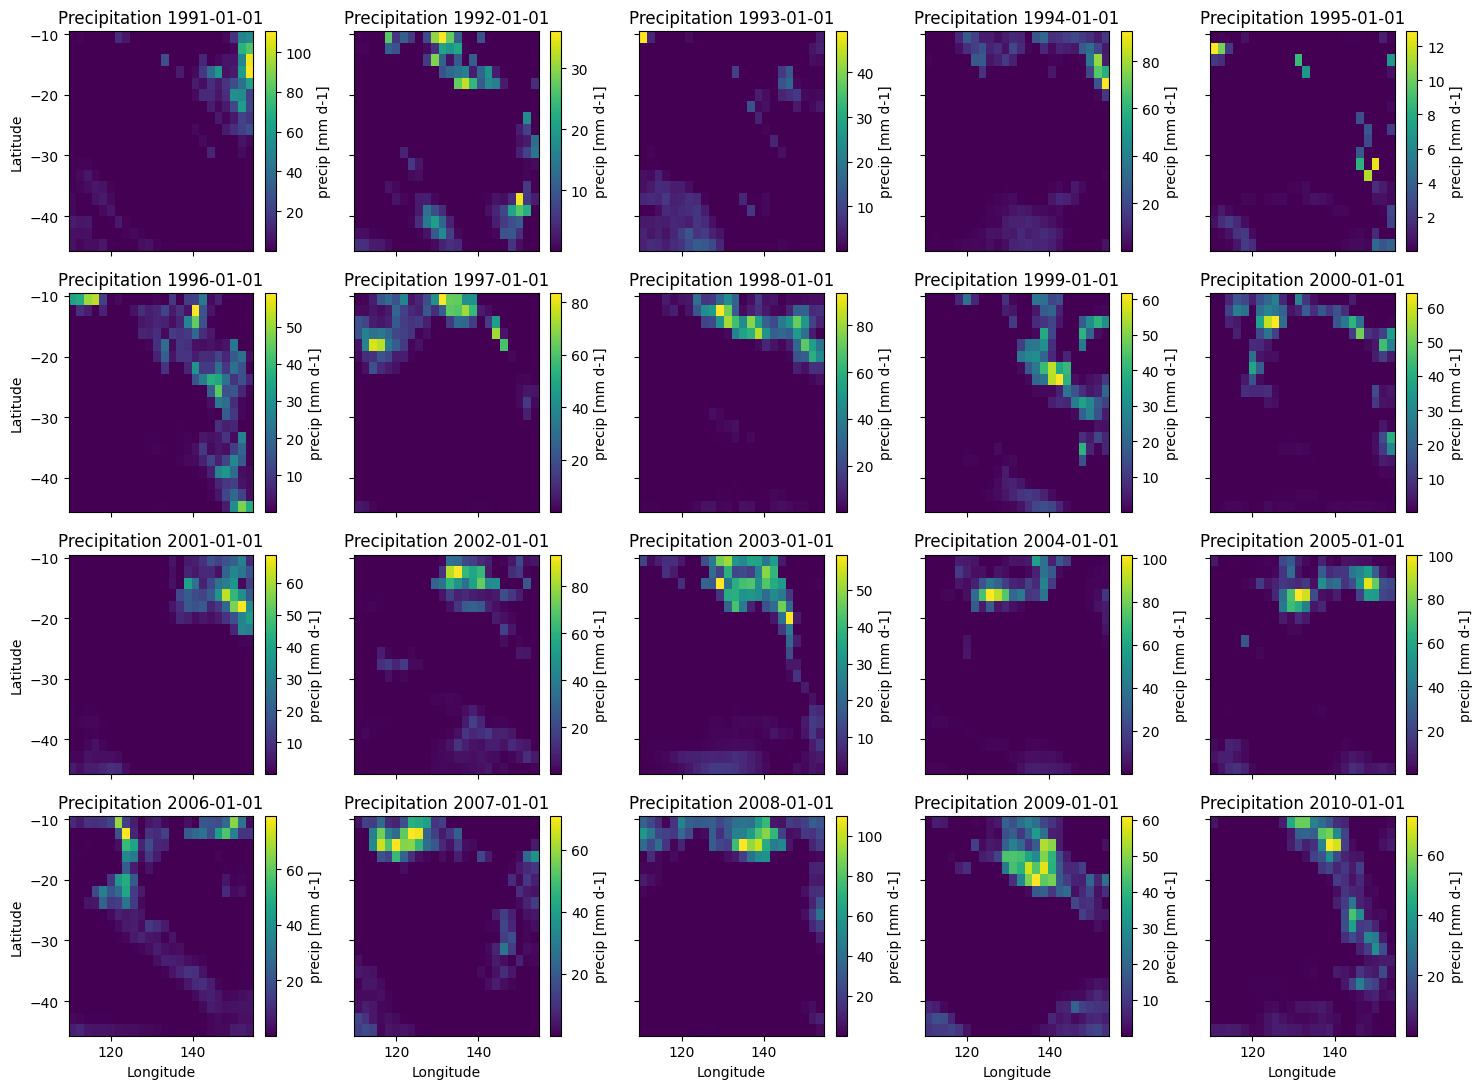

In [6]:
# Use year list to plot - It needs to be between 1991 and 2010

fig, axs = plt.subplots(4, 5, sharex=True, sharey=True)
for i, ax in enumerate(axs.flat):
    if i < len(yrs_lt):
        year_str = str(yrs_lt[i]) + '-01-01 00:00:00' # This can be modified to add other month or date
        xc_dataset['precip'].sel(time=year_str).plot(ax= ax, x='lon', y='lat')
        ax.set_title('Precipitation ' + str(yrs_lt[i]) + '-01-01')
        # Remove axis label to enable common label at the end
        ax.set_ylabel('')
        ax.set_xlabel('')
    else:
        break

# set labels
plt.setp(axs[-1, :], xlabel='Longitude')
plt.setp(axs[:, 0], ylabel='Latitude')

# Make sure it show a nice layout avoiding overlapping
plt.tight_layout()

#### 2.3. Xclim computation

- The list of indices can be found [here](https://xclim.readthedocs.io/en/latest/indicators_api.html)
- The indicator chosen are:
    R10mm / R20mm / CDD / CWD / SDII / RX1day / RX5day / PRCPTOT

In [10]:
# Indicators

# R10mm
# r_10 = xc.indices._threshold.wetdays(dataset.precip, thresh='10 mm/day', freq='YS')
r_10 = xc.indicators.icclim.R10mm(xc_dataset.precip, freq='YS')

# R20mm
# r_20 = xc.indices._threshold.wetdays(dataset.precip, thresh='20 mm/day', freq='YS')
r_20 = xc.indicators.icclim.R20mm(xc_dataset.precip, freq='YS')

# CDD
# cdd = xc.indices._threshold.maximum_consecutive_dry_days(xc_dataset.precip, thresh='1 mm/day', freq='YS')
cdd = xc.indicators.icclim.CDD(xc_dataset.precip, freq='YS')
    
# CWD
# cwd = xc.indices._threshold.maximum_consecutive_wet_days(dataset.precip, thresh='1 mm/day', freq='YS')
cwd = xc.indicators.cf.cwd(xc_dataset.precip, freq='YS')

# SDII
# sdii = out = xc.indices._threshold.daily_pr_intensity(dataset.precip, thresh='1 mm/day', freq='YS')
sdii = xc.indicators.atmos.daily_pr_intensity(xc_dataset.precip, freq='YS')

# RX1day
rx1 = xc.indicators.atmos.max_1day_precipitation_amount(xc_dataset.precip, freq='YS')

# RX5day
rx5 = xc.indicators.icclim.RX5day(xc_dataset.precip, freq='YS')

# PRCPTOT
prcp_tot = xc.indicators.atmos.precip_accumulation(xc_dataset.precip, freq='YS')
# prcp_tot = xc.indicators.atmos.liquid_precip_accumulation(xc_dataset.precip, tas = xc_dataset.tmin, freq='YS')

# We have created an xarray data-array - 
# We can insert this into an output xr.Dataset object with a copy of the original dataset global attrs
ds_xcOutput = xr.Dataset(attrs=xc_dataset.attrs)

# Add our climate index as a data variable to the dataset
ds_xcOutput ['r10mm'] = r_10
ds_xcOutput ['r20mm'] = r_20
ds_xcOutput ['cdd'] = cdd
ds_xcOutput ['cwd'] = cwd
ds_xcOutput ['sdii'] = sdii
ds_xcOutput ['rx1day'] = rx1
ds_xcOutput ['rx5day'] = rx5
ds_xcOutput ['prcptot'] = prcp_tot

# Check output
ds_xcOutput

/home/lfpv/.local/lib/python3.8/site-packages/xclim/core/cfchecks.py:40: UserWarning: Variable does not have a `cell_methods` attribute.
  check_valid(
/home/lfpv/.local/lib/python3.8/site-packages/xclim/core/cfchecks.py:44: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(var, "standard_name", data["standard_name"])
/home/lfpv/.local/lib/python3.8/site-packages/xclim/core/cfchecks.py:40: UserWarning: Variable does not have a `cell_methods` attribute.
  check_valid(
/home/lfpv/.local/lib/python3.8/site-packages/xclim/core/cfchecks.py:44: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(var, "standard_name", data["standard_name"])
/home/lfpv/.local/lib/python3.8/site-packages/xclim/core/cfchecks.py:40: UserWarning: Variable does not have a `cell_methods` attribute.
  check_valid(
/home/lfpv/.local/lib/python3.8/site-packages/xclim/core/cfchecks.py:44: UserWarning: Variable does not have a `standard_name` attribute.
  check_vali

<xarray.Dataset>
Dimensions:  (lat: 19, lon: 24, time: 20)
Coordinates:
  * time     (time) datetime64[ns] 1991-01-01 1992-01-01 ... 2010-01-01
  * lon      (lon) float32 110.6 112.5 114.4 116.2 ... 148.1 150.0 151.9 153.8
  * lat      (lat) float32 -10.48 -12.38 -14.29 -16.19 ... -40.95 -42.86 -44.76
Data variables:
    r10mm    (time, lat, lon) float64 18.0 18.0 18.0 18.0 ... 18.0 20.0 23.0
    r20mm    (time, lat, lon) float64 10.0 10.0 8.0 6.0 9.0 ... 0.0 1.0 4.0 6.0
    cdd      (time, lat, lon) float64 94.0 110.0 104.0 54.0 ... 14.0 15.0 14.0
    cwd      (time, lat, lon) float64 8.0 7.0 9.0 7.0 8.0 ... 8.0 8.0 14.0 13.0
    sdii     (time, lat, lon) float64 12.16 10.99 9.663 ... 5.359 5.592 5.943
    rx1day   (time, lat, lon) float32 90.28 51.98 50.57 ... 28.46 35.68 44.88
    rx5day   (time, lat, lon) float32 157.7 85.29 69.99 ... 44.45 57.12 59.79
    prcptot  (time, lat, lon) float32 658.7 646.6 525.6 ... 928.6 1.034e+03
Attributes:
    history:  Thu Jun 17 12:22:44 2021: ncatted -O -a units,precip,m,c,mm d-1...
    NCO:      netCDF Operators version 4.9.1 (Homepage = http://nco.sf.net, C...

### 3. EPCI computations Climpact

- Climpact indices computations were done using R. In this notebook I am only working with the output of the climpact tool. Further details of how to run the Climpact computation can be found [here](https://github.com/ARCCSS-extremes/climpact)

The outputs use here correspond to the following indicators:
    R10mm / R20mm / CDD / CWD / SDII / RX1day / RX5day / PRCPTOT

#### 3.1. Loading and reading nc file

In [27]:
# Add files as individual variables
path = Path(input_folder / 'climpact_R_outputs_exampleData_notebookWork') 
climpact_files = path.glob('**/*.nc')

# Create xarray to store variable values
ds_clOutput = xr.Dataset(attrs=xc_dataset.attrs)

for cl_file in climpact_files:
    # read variable based on the file name
    if cl_file.name.split('_')[0] == 'r10mm':
        climpact = xr.load_dataset(cl_file)
        ds_clOutput['r10mm'] = climpact['r10mm']
    if cl_file.name.split('_')[0] == 'r20mm':
        climpact = xr.load_dataset(cl_file)
        ds_clOutput['r20mm'] = climpact['r20mm']
    if cl_file.name.split('_')[0] == 'cdd':
        climpact = xr.load_dataset(cl_file)
        ds_clOutput['cdd'] = climpact['cdd']
    if cl_file.name.split('_')[0] == 'cwd':
        climpact = xr.load_dataset(cl_file)
        ds_clOutput['cwd'] = climpact['cwd']
    if cl_file.name.split('_')[0] == 'sdii':
        climpact = xr.load_dataset(cl_file)
        ds_clOutput['sdii'] = climpact['sdii']    
    if cl_file.name.split('_')[0] == 'rx1day':
        climpact = xr.load_dataset(cl_file)
        ds_clOutput['rx1day'] = climpact['rx1day']
    if cl_file.name.split('_')[0] == 'rx5day':
        climpact = xr.load_dataset(cl_file)
        ds_clOutput['rx5day'] = climpact['rx5day']
    if cl_file.name.split('_')[0] == 'prcptot':
        climpact = xr.load_dataset(cl_file)
        ds_clOutput['prcptot'] = climpact['prcptot']



# Change long name ready for graphs
ds_clOutput.prcptot.attrs["long_name"] = 'Total precipitation'
# Check output
ds_clOutput

<xarray.Dataset>
Dimensions:  (lat: 19, lon: 24, time: 20)
Coordinates:
  * time     (time) datetime64[ns] 1991-07-02 1992-07-01T12:00:00 ... 2010-07-02
  * lon      (lon) float64 110.6 112.5 114.4 116.2 ... 148.1 150.0 151.9 153.8
  * lat      (lat) float64 -10.48 -12.38 -14.29 -16.19 ... -40.95 -42.86 -44.76
Data variables:
    cdd      (time, lat, lon) timedelta64[ns] 94 days 110 days ... 14 days
    cwd      (time, lat, lon) timedelta64[ns] 8 days 7 days ... 14 days 13 days
    prcptot  (time, lat, lon) float32 644.7 637.1 512.1 ... 900.3 1.004e+03
    r10mm    (time, lat, lon) timedelta64[ns] 18 days 18 days ... 23 days
    r20mm    (time, lat, lon) timedelta64[ns] 10 days 10 days ... 4 days 6 days
    rx1day   (time, lat, lon) float32 90.28 51.98 50.57 ... 28.46 35.68 44.88
    rx5day   (time, lat, lon) float32 157.7 85.29 69.99 ... 44.45 57.12 59.79
    sdii     (time, lat, lon) float32 12.16 10.99 9.663 ... 5.359 5.592 5.943
Attributes:
    history:  Thu Jun 17 12:22:44 2021: ncatted -O -a units,precip,m,c,mm d-1...
    NCO:      netCDF Operators version 4.9.1 (Homepage = http://nco.sf.net, C...

### 4. Quantification of the agreement between the measurements

The paper by [Giavarina, D., 2015](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4470095/) has been used as reference for this analysis.

The following two assumptions are to be considered:
- Measurements obtained from the two methods should give the same results, thus, the differences between measurments would be equal to zero;
- If variability between methods is ony linked to analytical imprecesion (i.e. different programming languages) then, the average of the difference should be zero

#### 4.1. Checking the difference between measurements

In [12]:
#List to store arrays where mean difference is > 0
arr_cl = []
arr_xc = []
arr_in = []
arr_yr = []
arr_df = []

# list of indicators
ind_lt = ['r10mm', 'r20mm', 'cdd', 'cwd', 'sdii', 'rx1day', 'rx5day', 'prcptot']


# # Create dataframe to store final values and add indicators as column
ba_df = pd.DataFrame({'':ind_lt})

# Finding difference between measurements and average per year and indicator
for year in yrs_lt:
    mean_lt = []
    # List to store mean of difference
    for indicator in ind_lt:
        sel_xs = str(year) + '-01-01 00:00:00'
        sel_cl_leap = str(year) + '-07-01 12:00:00'
        sel_cl_nolp = str(year) + '-07-02 00:00:00'
        
        # Get values from xarrays
        ind_val_xc = ds_xcOutput[indicator].sel(time=sel_xs).values

        # Check if year is even to use the right time selector
        if year in [1992, 1996, 2000, 2004, 2008]:
            ind_val_cl = ds_clOutput[indicator].sel(time=sel_cl_leap).values
        else:
            ind_val_cl = ds_clOutput[indicator].sel(time=sel_cl_nolp).values
            
        # Flatten arrays ready to find difference between methods
        ind_xc_final = ind_val_xc.flatten()
        if indicator in ['r10mm', 'r20mm', 'cdd', 'cwd']:
            # this uses timedelta to read value as a day before flatten the array
            ind_cl_final = (ind_val_cl / np.timedelta64(1, 'D')).astype(int).flatten()
        else:
            ind_cl_final = ind_val_cl.flatten()
        
        # differences and difference average between measurements using the normalized data
        difference = ind_cl_final - ind_xc_final
        
        # Append mean of difference to list, rounded to two decimal places using rounding function
        mean_val = np.mean(difference)
        mean_rnd = rounding(mean_val)
        mean_lt.append(mean_rnd)
        
        # Append values to arrays ready for analysis
        if abs(mean_rnd) > 0:
            arr_cl.append(ind_cl_final)
            arr_xc.append(ind_xc_final)
            arr_in.append(indicator)
            arr_yr.append(year)
            arr_df.append(difference)

#         print('This is the indicator: {} and the mean of the difference is: {}'.format(indicator, np.mean(difference)))
    # Add mean values to daframe
    ba_df[year] = mean_lt


#Add the mean for each row in the dataframe
ba_df['mean'] = ba_df.mean(axis=1).round(decimals=2)
ba_df.transpose()

,0,1,2,3,4,5,6,7
,r10mm,r20mm,cdd,cwd,sdii,rx1day,rx5day,prcptot
1991,0.0,0.0,-8.81,0.0,0.01,0.0,0.04,-15.6
1992,0.0,0.0,7.33,0.0,0.01,0.0,0.04,-17.07
1993,0.0,0.0,4.15,0.01,0.01,0.0,0.04,-17.08
1994,0.0,0.0,0.59,0.02,0.01,0.0,-0.61,-15.87
1995,0.0,0.0,3.25,0.0,0.01,0.0,0.08,-16.58
1996,0.0,0.0,1.19,0.03,0.01,0.0,0.07,-15.92
1997,0.0,0.0,-1.09,0.03,0.01,0.0,-1.55,-16.93
1998,0.0,0.0,4.46,0.22,0.01,0.0,0.24,-17.55
1999,0.0,0.0,0.7,0.09,0.0,0.0,-0.35,-16.89


#### 4.2. Calcuating Precipitation Total index myself

In [13]:
# Create raw dataset xarray
raw_dataset = xr.load_dataset(input_folder / 
                              'climpact_R_outputs_exampleData_notebookWork/climpact_sampledata_gridded_1991_2010_rainWork.nc')

# Group by year and sum precip
manual_precipTot = raw_dataset['precip'].groupby('time.year').sum('time')
# test = monthly_dataset['precip'].sel(time='2010-01-01 00:00:00').values

# Checking the difference for precipation total between Xclim, Climpact, and own calculation
xc_cl_arr = []
cl_mn_arr = []
xc_mn_arr = []

# Finding difference between measurements and average per year and indicator
for year in yrs_lt:
    sel_xs = str(year) + '-01-01 00:00:00'
    sel_cl_leap = str(year) + '-07-01 12:00:00'
    sel_cl_nolp = str(year) + '-07-02 00:00:00'

    # Reading Xclim and Climpact data - Get values from xarrays
    prc_val_xc = ds_xcOutput['prcptot'].sel(time=sel_xs).values

    # Check if year is even to use the right time selector
    if year in [1992, 1996, 2000, 2004, 2008]:
        prc_val_cl = ds_clOutput['prcptot'].sel(time=sel_cl_leap).values
    else:
        prc_val_cl = ds_clOutput['prcptot'].sel(time=sel_cl_nolp).values
    
    # Reading own calculation data - Get values from xarrays
    idx = yrs_lt.index(year)
    prc_val_mn =  manual_precipTot[idx].values
    
    
    # Flatten arrays ready to find difference between methods
    prc_xc = prc_val_xc.flatten()
    prc_cl = prc_val_cl.flatten()
    prc_mn = prc_val_mn.flatten()
    
    # differences and difference average between measurements using the normalized data
    diff_xc_cl = prc_cl - prc_xc
    diff_cl_mn = prc_cl - prc_mn
    diff_xc_mn = prc_xc - prc_mn

    # Append mean of difference to list, rounded to two decimal places
    mean_diff_xc_cl = np.mean(diff_xc_cl)
    mean_diff_cl_mn = np.mean(diff_cl_mn)
    mean_diff_xc_mn = np.mean(diff_xc_mn)
    
    # add to list ready for dataframe
    xc_cl_arr.append(rounding(mean_diff_xc_cl))
    cl_mn_arr.append(rounding(mean_diff_cl_mn))
    xc_mn_arr.append(rounding(mean_diff_xc_mn))

# Create dataframe to store final values and add indicators as column
mnCheck_df = pd.DataFrame({'years': yrs_lt, 'Climpact - Xclim': xc_cl_arr,
                          'Climpact - Manual Check': cl_mn_arr, 'Xclim - Manual Check': xc_mn_arr})

mnCheck_df


,years,Climpact - Xclim,Climpact - Manual Check,Xclim - Manual Check
0,1991,-15.60,-15.60,0.0
1,1992,-17.07,-17.07,0.0
2,1993,-17.08,-17.08,0.0
3,1994,-15.87,-15.87,0.0
4,1995,-16.58,-16.58,0.0
5,1996,-15.92,-15.92,0.0
6,1997,-16.93,-16.93,0.0
7,1998,-17.55,-17.55,0.0
8,1999,-16.89,-16.89,0.0
9,2000,-16.93,-16.93,0.0


#### 4.3. Creating difference Maps

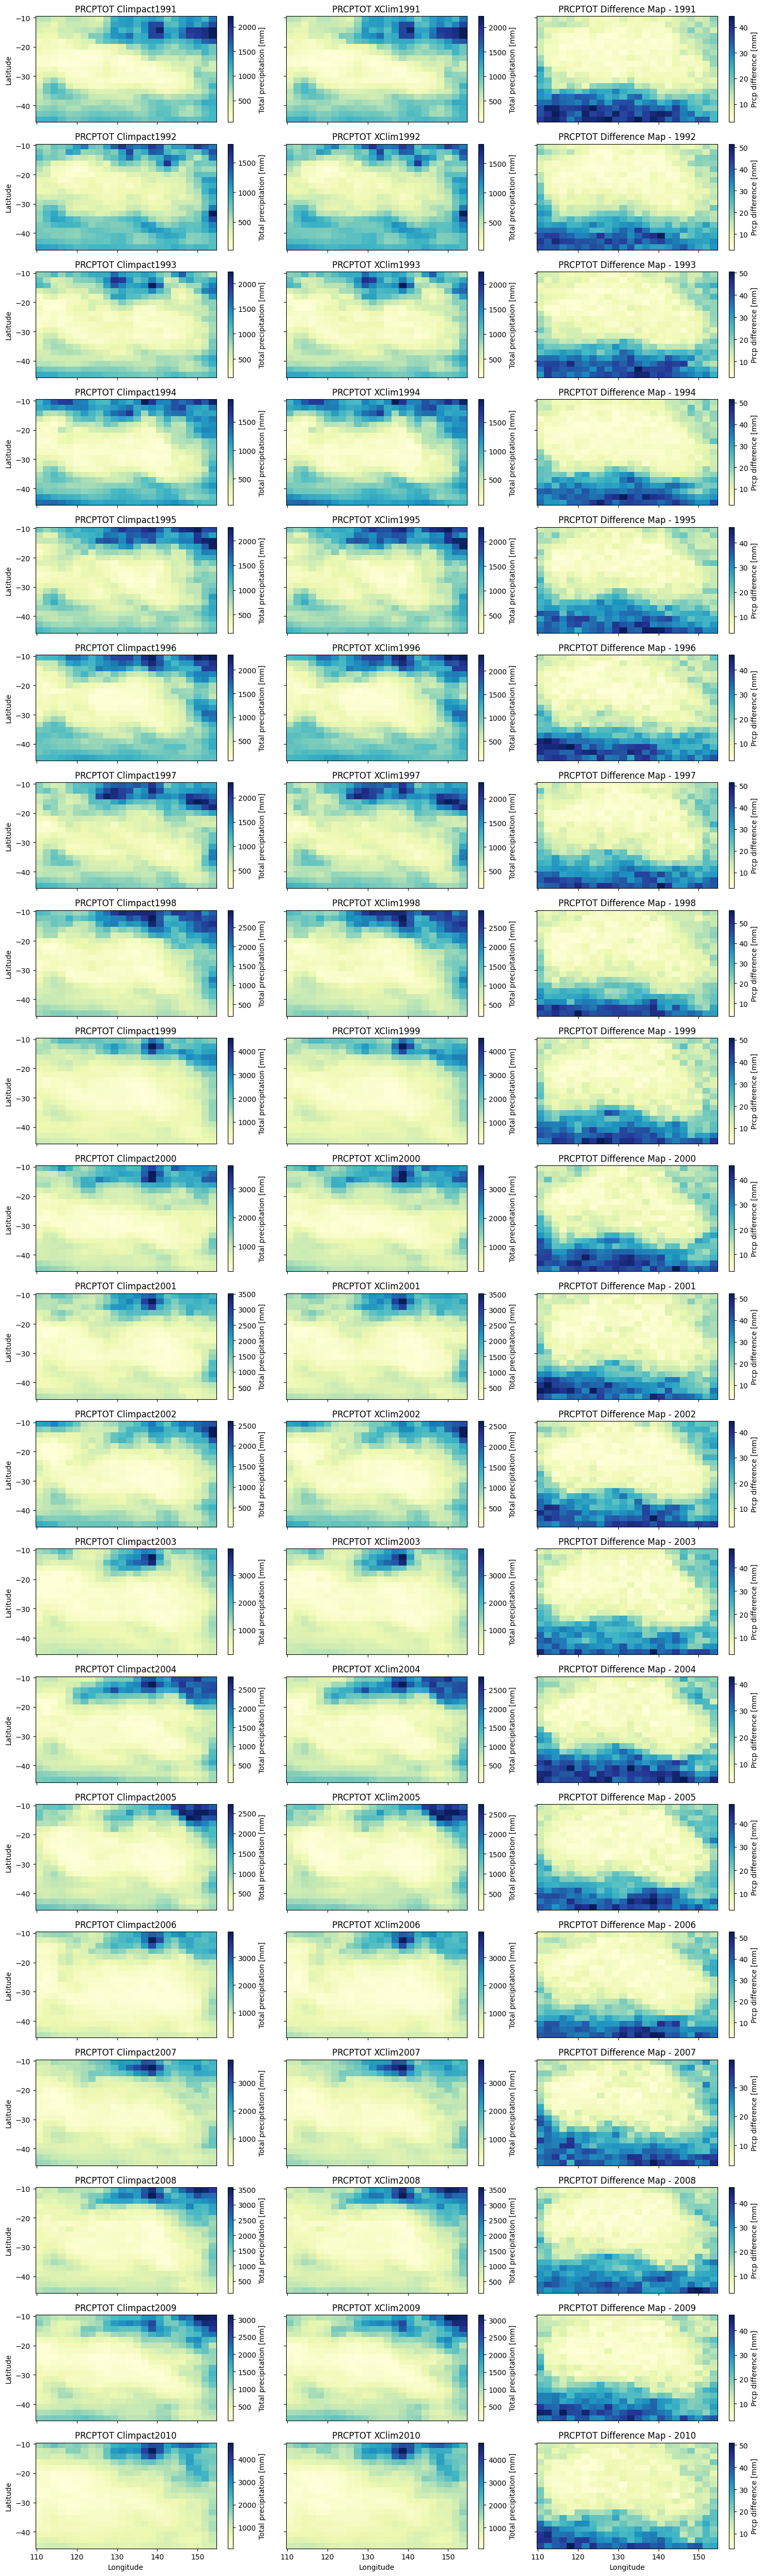

In [69]:
# Function to save subplot
def saveSubplot(ax_ref, file_name):  
    # Save just the portion _inside_ the second axis's boundaries
    extent = ax_ref.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # Pad the saved area by 10% in the x-direction and 20% in the y-direction
    fig.savefig(file_name, bbox_inches=extent.expanded(1.45, 1.3))
    
nrow = len(yrs_lt)

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(nrow, 3, sharex=True, sharey=True, figsize=(15,50))

j = 0
i = 0
while i < len(yrs_lt):
    if yrs_lt[i] in [1992, 1996, 2000, 2004, 2008]:
        sel_xs = str(yrs_lt[i]) + '-01-01 00:00:00'
        sel_cl_leap = str(yrs_lt[i]) + '-07-01 12:00:00'
        
        ds_clOutput['prcptot'].sel(time=sel_cl_leap).plot(ax= axs[i, j], x='lon', y='lat', cmap='YlGnBu')
        axs[i, j].set_title('PRCPTOT Climpact' + str(yrs_lt[i]))
        axs[i, j].set_ylabel('')
        axs[i, j].set_xlabel('')
        
        ds_xcOutput['prcptot'].sel(time=sel_xs).plot(ax= axs[i, j + 1], x='lon', y='lat', cmap='YlGnBu')
        axs[i, j + 1].set_title('PRCPTOT XClim' + str(yrs_lt[i]))
        axs[i, j + 1].set_ylabel('')
        axs[i, j + 1].set_xlabel('')
        
        diff_map = ds_xcOutput['prcptot'].sel(time=sel_xs) - ds_clOutput['prcptot'].sel(time=sel_cl_leap)
        diff_map.plot(ax= axs[i, j + 2], x='lon', y='lat', cmap='YlGnBu', cbar_kwargs={'label': 'Prcp difference [mm]'})
        axs[i, j + 2].set_title('PRCPTOT Difference Map - ' + str(yrs_lt[i]))
        axs[i, j + 2].set_ylabel('')
        axs[i, j + 2].set_xlabel('')
    else:
        sel_xs = str(yrs_lt[i]) + '-01-01 00:00:00'
        sel_cl_nolp = str(yrs_lt[i]) + '-07-02 00:00:00'
        
        ds_clOutput['prcptot'].sel(time=sel_cl_nolp).plot(ax= axs[i, j], x='lon', y='lat', cmap='YlGnBu')
        axs[i, j].set_title('PRCPTOT Climpact' + str(yrs_lt[i]))
        axs[i, j].set_ylabel('')
        axs[i, j].set_xlabel('')
        
        ds_xcOutput['prcptot'].sel(time=sel_xs).plot(ax= axs[i, j + 1], x='lon', y='lat', cmap='YlGnBu')
        axs[i, j + 1].set_title('PRCPTOT XClim' + str(yrs_lt[i]))
        axs[i, j + 1].set_ylabel('')
        axs[i, j + 1].set_xlabel('')
        
        diff_map = ds_xcOutput['prcptot'].sel(time=sel_xs) - ds_clOutput['prcptot'].sel(time=sel_cl_nolp)
        diff_map.plot(ax= axs[i, j + 2], x='lon', y='lat', cmap='YlGnBu', cbar_kwargs={'label': 'Prcp difference [mm]'})
        axs[i, j + 2].set_title('PRCPTOT Difference Map - ' + str(yrs_lt[i]))
        axs[i, j + 2].set_ylabel('')
        axs[i, j + 2].set_xlabel('')
        if i == 0:
            file_name = 'plot_' + str(yrs_lt[i])
            saveSubplot(axs[i, j + 2], file_name)
    # increase loop
    i +=1 

    
# set labels
plt.setp(axs[-1, :], xlabel='Longitude')
plt.setp(axs[:, 0], ylabel='Latitude')
# Make sure it show a nice layout avoiding overlapping
plt.tight_layout()




In [351]:
ds_clOutput.prcptot.attrs["long_name"] = 'Total precipitation'

ds_clOutput

<xarray.Dataset>
Dimensions:  (lat: 19, lon: 24, time: 20)
Coordinates:
  * time     (time) datetime64[ns] 1991-07-02 1992-07-01T12:00:00 ... 2010-07-02
  * lon      (lon) float64 110.6 112.5 114.4 116.2 ... 148.1 150.0 151.9 153.8
  * lat      (lat) float64 -10.48 -12.38 -14.29 -16.19 ... -40.95 -42.86 -44.76
Data variables:
    cdd      (time, lat, lon) timedelta64[ns] 94 days 110 days ... 14 days
    cwd      (time, lat, lon) timedelta64[ns] 8 days 7 days ... 14 days 13 days
    prcptot  (time, lat, lon) float32 644.7 637.1 512.1 ... 900.3 1.004e+03
    r10mm    (time, lat, lon) timedelta64[ns] 18 days 18 days ... 23 days
    r20mm    (time, lat, lon) timedelta64[ns] 10 days 10 days ... 4 days 6 days
    rx1day   (time, lat, lon) float32 90.28 51.98 50.57 ... 28.46 35.68 44.88
    rx5day   (time, lat, lon) float32 157.7 85.29 69.99 ... 44.45 57.12 59.79
    sdii     (time, lat, lon) float32 12.16 10.99 9.663 ... 5.359 5.592 5.943
Attributes:
    history:  Thu Jun 17 12:22:44 2021: ncatted -O -a units,precip,m,c,mm d-1...
    NCO:      netCDF Operators version 4.9.1 (Homepage = http://nco.sf.net, C...

---
---

#### 4.2 Test Normality of the differences where mean average greater than zero

In [314]:
# i = 0
# while i < len(arr_df):
#     print('-----------')
#     print('-----------')
#     print('{} - {} average of difference: {}'.format(arr_in[i].upper(), arr_yr[i], np.mean(arr_df[i])))
    
#     # normality test
# #     data = norm.ppf(rankdata(arr_df[i])/(len(arr_df[i]) + 1))
# #     norm_anderson(data)
# #     norm_shapiro(data)
#     # qqplot
# #     ax = plt.subplot(111)
# #     res = stats.probplot(data, plot=plt)
# #     plt.show()
    
# #     Box-Cox Transformation
# #     data_trans, lmbda = stats.boxcox(arr_df[i])
    
    
#     i += 1
#     break

#### 4.3. Bland-Altman Graph Output

Based on [Verkuilen, J., & Amanmyradova, A.; 2017](https://scholar.google.com/scholar_url?url=https://www.academia.edu/download/54577448/kde_baplot_092917.pdf&hl=en&sa=T&oi=gsb-ggp&ct=res&cd=0&d=2968932410156448367&ei=9pPZYO-1FdC5mAHu1ZqwAw&scisig=AAGBfm1GYQbvDvk5udRT_Dmmit3TInAjtQ) whenever a transformaton or regression of the data, the LoAs are often estimated
by simple empirical 2.5% and 97.5% quantiles

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  -82.  -95.    0. -101.    0.    0.  -98. -119.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  -61.  -64.  -61.  -60.  -64.  -79.  -73.  -24.  -25.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  -59.  -85. -102. -104. -103. -142.  -41.   56.   29.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  -56.  -90. -157.  -46.  -70.  -69.  -64.   59.   31.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  -56. -124. -137.  -78.  -64.  -45.  -44.   14.   32.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.  -

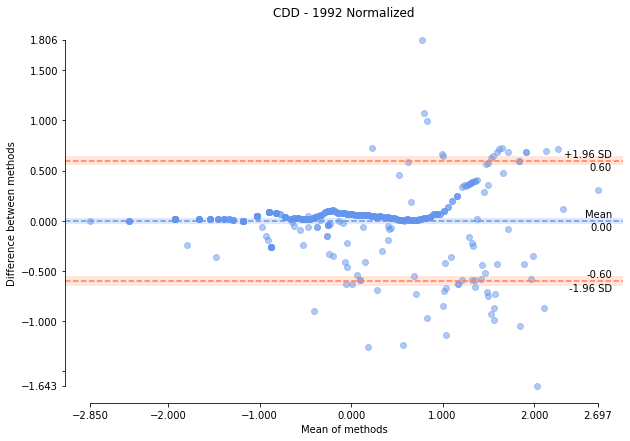

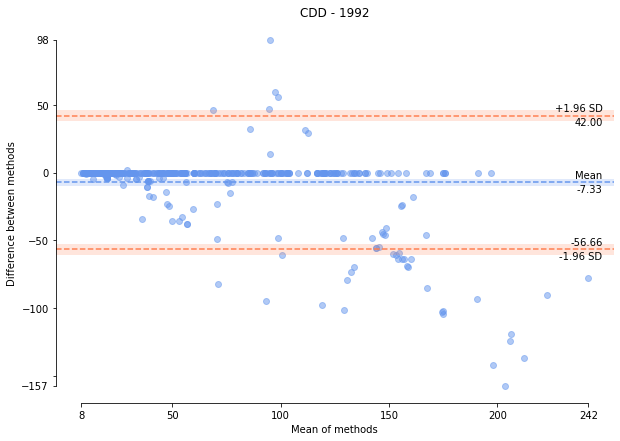

In [262]:
i = 3
while i < len(arr_cl):
    print(arr_xc[i] -arr_cl[i])
    print('------------------------------------------------------------')
    print('------------------------------------------------------------')
    Title_nm = arr_in[i].upper() + ' - ' + str(arr_yr[i]) + ' Normalized'
    pyCompare.blandAltman(arr_xc_nm[i], arr_cl_nm[i], title=Title_nm)
    Title = arr_in[i].upper() + ' - ' + str(arr_yr[i])
    pyCompare.blandAltman(arr_xc[i], arr_cl[i], title=Title)
    i += 1
    break